In [ ]:
# Enze Xu
# Github: https://github.com/EnzeXu/PINN
# git clone https://github.com/EnzeXu/PINN.git

import torch
import time
import random
import argparse
import math
import os
import copy
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from scipy import stats
from tqdm import tqdm
from collections import OrderedDict
from torchsummary import summary
from torch.backends import cudnn
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from torch.utils.tensorboard import SummaryWriter

from google.colab import drive
import sys
drive.mount("/content/drive")

main_path = '/content/drive/My Drive/enze/workspace/PINN/' # ENZE marked: you need to change your main_path if it's not here
sys.path.append(main_path)
from cyclic_lr_scheduler import CyclicLR
from utils import draw_two_dimension, draw_two_dimension_different_x, draw_multiple_loss, MultiSubplotDraw

Mounted at /content/drive


In [ ]:
kscln=0.2
kdcln=0.2
kasbf1=1
kasbf=10
kisbf=25
Jsbf=1
ksclbs=0.15
kdclbs1=0.1
kdclbs=0.05
ksnrm1=0.05 
kdnrm1=0.1
MBFtot=0.5
kass1=1
kdiss1=0.001
Jmbf=0.01
ksclbm1=0.01
ksclbm=0.01
kdclbm1=0.01
kdclbm=1
Jclbm=0.05
n=2
kspolo=0.01
kdpolo1=0.01
kdpolo=1
kacdc14=1
kicdc14=0.25
Jcdc14=0.01
kssic1=0.02
kdsic1=0.01
kdsic=2
Jsic1=0.01
Kdiss=0.05
kacdh11=1
kacdh1=10
kicdh11=0.2
kicdh1=10
Jcdh1=0.01
ndClbM=0


Cln_start = 0.05
ClbSt_start = 0.045
MBF_start = 0.02
Nrm1t_start = 0.54
ClbMt_start = 0.9
Polo_start = 0.25
Sic1t_start = 0.01
SBF_start = 0.031
Cdh1_start = 0.0005
Cdc14_start= 0.1

In [ ]:
class GroundTruthBYCC:
  def __init__(self):
    np.random.seed(0)
    #inital condition
    Cln_start = 0.05
    ClbSt_start = 0.045
    MBF_start = 0.02
    Nrm1t_start = 0.54
    ClbMt_start = 0.9
    Polo_start = 0.25
    Sic1t_start = 0.01
    SBF_start = 0.031
    Cdh1_start = 0.0005
    Cdc14_start= 0.1

    #time points
    self.config = ConfigBYCC()
    self.t = np.linspace(0, self.config.T - self.config.T_unit, self.config.N)
    # print(t)

    #solve ODEs
    self.y0 = np.asarray([Cln_start,ClbSt_start,MBF_start,Nrm1t_start,ClbMt_start,Polo_start,Sic1t_start,SBF_start,Cdh1_start,Cdc14_start])
    # print(y0.shape)
    self.sol = odeint(self.pend, self.y0, self.t, args=(kscln,kdcln,kasbf1,kasbf,kisbf,kdclbs1,kdclbs,ksnrm1,kdnrm1,MBFtot,kass1,kdiss1,Jmbf,ksclbm1,ksclbm,kdclbm1,
         kdclbm,Jclbm,n,kspolo,kdpolo1,kdpolo,kacdc14,kicdc14,Jcdc14,kssic1,kdsic1,kdsic,Jsic1,Kdiss,kacdh11,kacdh1,kicdh11,kicdh1,
         Jcdh1,ndClbM))
    self.y = self.sol
    
  def pend(self,y,t,kscln,kdcln,kasbf1,kasbf,kisbf,kdclbs1,kdclbs,ksnrm1,kdnrm1,MBFtot,kass1,kdiss1,Jmbf,ksclbm1,ksclbm,kdclbm1,
           kdclbm,Jclbm,n,kspolo,kdpolo1,kdpolo,kacdc14,kicdc14,Jcdc14,kssic1,kdsic1,kdsic,Jsic1,Kdiss,kacdh11,kacdh1,kicdh11,kicdh1,
           Jcdh1,ndClbM):
    #assign each ode to a vector element 
    Cln = y[0]
    ClbSt = y[1]
    MBF = y[2]
    Nrm1t = y[3]
    ClbMt = y[4]
    Polo = y[5]
    Sic1t = y[6]
    SBF = y[7]
    Cdh1 = y[8]
    Cdc14 = y[9]

    d_Cln = kscln*SBF - kdcln*Cln
    d_ClbSt = ksclbs*(MBF*Cln/(Jmbf + Cln)) - (kdclbs1 + kdclbs*Cdh1)*ClbSt
    d_MBF = kdiss1*(MBFtot - MBF) - kass1*MBF*(Nrm1t - (MBFtot - MBF))
    d_Nrm1t = ksnrm1*(MBF*Cln/(Jmbf + Cln)) - kdnrm1*Cdh1*Nrm1t
    d_ClbMt = ksclbm1 + ksclbm*((ClbMt+ndClbM)*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + math.sqrt((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM)))))/(ClbSt + ClbMt + ndClbM))**n/(Jclbm**n + ((ClbMt + ndClbM)*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + math.sqrt((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM)))))/(ClbSt + ClbMt + ndClbM))**n) - (kdclbm1 + kdclbm*Cdh1)*ClbMt
    d_Polo = kspolo*((ClbMt+ndClbM)*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + math.sqrt((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM)))))/(ClbSt + ClbMt + ndClbM)) - (kdpolo1 + kdpolo*Cdh1)*Polo
    d_Sic1t = kssic1 - (kdsic1 + kdsic*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + math.sqrt((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM)))))*(Cln+((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + math.sqrt((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))))))/(Jsic1+Cln+((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + math.sqrt((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM)))))))*Sic1t
    d_SBF = (kasbf1 + kasbf*Cln)*(1-SBF)/(Jsbf + 1 - SBF) - kisbf*((ClbMt+ndClbM)*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + math.sqrt((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM)))))/(ClbSt + ClbMt + ndClbM))*SBF/(Jsbf + SBF)
    d_Cdh1 = (kacdh11 + kacdh1*Cdc14)*(1 - Cdh1)/(Jcdh1 + 1 - Cdh1) - (kicdh11*Cln + kicdh1*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + math.sqrt((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))))))*Cdh1/(Jcdh1 + Cdh1)
    d_Cdc14 = kacdc14*Polo*(1 - Cdc14)/(Jcdc14 + 1 - Cdc14) - kicdc14*Cdc14/(Jcdc14 + Cdc14)




    return [d_Cln,d_ClbSt,d_MBF,d_Nrm1t,d_ClbMt,d_Polo,d_Sic1t,d_SBF,d_Cdh1,d_Cdc14]


## Model

In [ ]:
class ConfigBYCC:
    def __init__(self):
      self.model_name = "SimpleNetworkBYCCContinue"
      self.T = 100.0
      self.T_all = self.T
      self.T_unit = 0.1
      self.N = int(self.T / self.T_unit)

      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.seed = 0


      self.ub = self.T
      self.lb = 0.0

      self.only_truth_flag = False  # True means only using loss_1 for truth_rate = 1.00, no other loss
      self.truth_rate = 0.005 # 0.0034#0.5# 0.0034 #0.0034 # 0.0034 * 300 = 1 point(s) as truth #1.00 #0.25 #0.0005
      self.truth_length = 1#int(self.truth_rate * self.T / self.T_unit)

      self.continuous_flag = False
      self.continue_period = 0.05
      self.round_bit = 3
      self.continue_id = 0

      self.x_real_all = np.asarray([i*self.T_unit for i in range(self.N)])


class ConfigBYCCComplete(ConfigBYCC):
    def __init__(self):
        ConfigBYCC.__init__(self)
        self.gt = GroundTruthBYCC()
        self.x_real = torch.tensor(np.asarray([[i*self.T_unit] * 10 for i in range(self.N)]) / self.T_all * 2.0 - 1.0).float().to(self.device)
        print("[continuous] self.x_real: shape = {}".format(self.x_real.shape))

def RMSELoss(y_pred, y):
    return torch.sqrt(torch.mean((y_pred - y)**2) + 1e-12)

class SimpleNetworkBYCC(nn.Module):
    def __init__(self, config, truth=None):
        super(SimpleNetworkBYCC, self).__init__()
        self.config = config
        print("self.truth_length: {} of {} all ".format(self.config.truth_length, self.config.N))
        self.setup_seed(self.config.seed)
        self.device = self.config.device
        self.x, self.y0, self.t0 = None, None, None
        self.accurate_x = None
        self.generate_x()

        self.initial_start()
        self.model_name = self.config.model_name
        self.gt = self.config.gt
        self.gt_data = torch.Tensor(self.gt.sol).to(self.device)
        self.y_record = None

        self.loss_1_start_index = int(self.config.T_all * self.config.continue_period / self.config.T_unit * self.config.continue_id)
        print("[Continue] loss_1_start_index ", self.loss_1_start_index)

        self.sig = nn.Tanh()

        self.loss_norm = RMSELoss
        self.truth = truth if truth else [[], []]
        self.truth_dic = {round(self.truth[0][i], self.config.round_bit): self.truth[1][i] for i in range(len(self.truth[0]))}

        self.network_unit = 20

        # self.criterion = torch.nn.MSELoss().to(self.device)
        # Design A
        # id = 1
        self.fc_x1 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))
        self.fc_x2 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))
        self.fc_x3 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))
        self.fc_x4 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))
        self.fc_x5 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))
        self.fc_x6 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))
        self.fc_x7 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))
        self.fc_x8 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))
        self.fc_x9 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))
        self.fc_x10 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))




    def forward(self, inputs):
        # print(inputs.shape)
        # print("inputs=", inputs)
        x1, x2, x3, x4, x5, x6, x7, x8, x9, x10 = torch.chunk(inputs, 10, 1)
        
        # Design A
        x1_new = self.fc_x1(x1)
        x2_new = self.fc_x2(x2)
        x3_new = self.fc_x3(x3)
        x4_new = self.fc_x4(x4)
        x5_new = self.fc_x5(x5)
        x6_new = self.fc_x6(x6)
        x7_new = self.fc_x7(x7)
        x8_new = self.fc_x8(x8)
        x9_new = self.fc_x9(x9)
        x10_new = self.fc_x10(x10)


        outputs = torch.cat((x1_new, x2_new, x3_new, x4_new, x5_new, x6_new, x7_new, x8_new, x9_new, x10_new), 1)
        return outputs

    def generate_x(self):
        x = [[i*self.config.T_unit]*10 for i in range(self.config.N)]  # toy
        x = np.asarray(x)
        x = self.encode_t(x)
        self.x = torch.Tensor(x).float().to(self.device)
        self.accurate_x = [i*self.config.T_unit for i in range(self.config.N)]

    def initial_start(self):
        self.t0 = torch.Tensor(np.asarray([-1.0]*10).reshape([1, -1])).float().to(self.device)
        self.y0 = torch.Tensor(np.asarray([Cln_start,ClbSt_start,MBF_start,Nrm1t_start,ClbMt_start,Polo_start,Sic1t_start,SBF_start,Cdh1_start,Cdc14_start]).reshape([1, -1])).float().to(self.device)

    def loss_only_ground_truth(self):
        self.eval()
        y = self.forward(self.x)
        y = y.type(torch.float64)

        Cln = y[:,0:1]
        ClbSt = y[:,1:2]
        MBF = y[:,2:3]
        Nrm1t = y[:,3:4]
        ClbMt = y[:,4:5]
        Polo = y[:,5:6]
        Sic1t = y[:,6:7]
        SBF = y[:,7:8]
        Cdh1 = y[:,8:9]
        Cdc14 = y[:,9:10]
       
        Cln_t = torch.gradient(Cln.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
        ClbSt_t = torch.gradient(ClbSt.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
        MBF_t = torch.gradient(MBF.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
        Nrm1t_t = torch.gradient(Nrm1t.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
        ClbMt_t = torch.gradient(ClbMt.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
        Polo_t = torch.gradient(Polo.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
        Sic1t_t = torch.gradient(Sic1t.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
        SBF_t = torch.gradient(SBF.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
        Cdh1_t = torch.gradient(Cdh1.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
        Cdc14_t = torch.gradient(Cdc14.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])

        Cln_t_target  = kscln*SBF - kdcln*Cln
        ClbSt_t_target = ksclbs*(MBF*Cln/(torch.abs(Jmbf + Cln)+1e-12)) - (kdclbs1 + kdclbs*Cdh1)*ClbSt
        MBF_t_target  = kdiss1*(MBFtot - MBF) - kass1*MBF*(Nrm1t - (MBFtot - MBF))
        Nrm1t_t_target = ksnrm1*(MBF*Cln/(torch.abs(Jmbf + Cln)+1e-12)) - kdnrm1*Cdh1*Nrm1t
        ClbMt_t_target = ksclbm1 + ksclbm*((ClbMt+ndClbM)*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12)))/(torch.abs(ClbSt + ClbMt + ndClbM)+1e-12))**n/(torch.abs(Jclbm**n + ((ClbMt + ndClbM)*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12)))/(torch.abs(ClbSt + ClbMt + ndClbM)+1e-12))**n)+1e-12) - (kdclbm1 + kdclbm*Cdh1)*ClbMt
        Polo_t_target  = kspolo*((ClbMt+ndClbM)*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12)))/(torch.abs(ClbSt + ClbMt + ndClbM)+1e-12)) - (kdpolo1 + kdpolo*Cdh1)*Polo
        Sic1t_t_target = kssic1 - (kdsic1 + kdsic*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12)))*(Cln+((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12))))/(torch.abs(Jsic1+Cln+((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12))))+1e-12))*Sic1t
        SBF_t_target  = (kasbf1 + kasbf*Cln)*(1-SBF)/(torch.abs(Jsbf + 1 - SBF)+1e-12) - kisbf*((ClbMt+ndClbM)*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12)))/(torch.abs(ClbSt + ClbMt + ndClbM)+1e-12))*SBF/(torch.abs(Jsbf + SBF)+1e-12)
        Cdh1_t_target  = (kacdh11 + kacdh1*Cdc14)*(1 - Cdh1)/(torch.abs(Jcdh1 + 1 - Cdh1)+1e-12) - (kicdh11*Cln + kicdh1*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12))))*Cdh1/(torch.abs(Jcdh1 + Cdh1)+1e-12)
        Cdc14_t_target = kacdc14*Polo*(1 - Cdc14)/(torch.abs(Jcdc14 + 1 - Cdc14)+1e-12) - kicdc14*Cdc14/(torch.abs(Jcdc14 + Cdc14)+1e-12)

        f_Cln = Cln_t  - Cln_t_target
        f_ClbSt = ClbSt_t - ClbSt_t_target
        f_MBF = MBF_t  - MBF_t_target
        f_Nrm1t = Nrm1t_t - Nrm1t_t_target
        f_ClbMt = ClbMt_t - ClbMt_t_target
        f_Polo = Polo_t - Polo_t_target 
        f_Sic1t = Sic1t_t - Sic1t_t_target
        f_SBF = SBF_t  - SBF_t_target
        f_Cdh1 = Cdh1_t - Cdh1_t_target 
        f_Cdc14 = Cdc14_t - Cdc14_t_target
        
        f_y = torch.cat((f_Cln, f_ClbSt, f_MBF, f_Nrm1t, f_ClbMt, f_Polo, f_Sic1t, f_SBF, f_Cdh1, f_Cdc14), 1)

        # print(y.shape, self.gt_data.shape)
        loss = self.loss_norm(y,self.gt_y)
        loss_2 = torch.mean(torch.square(f_y))
        self.train()
        return loss, [loss,loss_2]

    def real_loss(self):
        self.eval()
        y = self.forward(self.config.x_real)
        real_loss = self.loss_norm(y[:self.config.N, :], self.gt_data[:self.config.N, :])
        return real_loss

    def loss(self):
        self.eval()
        y = self.forward(self.x)
        Cln = y[:,0:1]
        ClbSt = y[:,1:2]
        MBF = y[:,2:3]
        Nrm1t = y[:,3:4]
        ClbMt = y[:,4:5]
        Polo = y[:,5:6]
        Sic1t = y[:,6:7]
        SBF = y[:,7:8]
        Cdh1 = y[:,8:9]
        Cdc14 = y[:,9:10]
       
        Cln_t = torch.gradient(Cln.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
        ClbSt_t = torch.gradient(ClbSt.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
        MBF_t = torch.gradient(MBF.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
        Nrm1t_t = torch.gradient(Nrm1t.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
        ClbMt_t = torch.gradient(ClbMt.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
        Polo_t = torch.gradient(Polo.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
        Sic1t_t = torch.gradient(Sic1t.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
        SBF_t = torch.gradient(SBF.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
        Cdh1_t = torch.gradient(Cdh1.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
        Cdc14_t = torch.gradient(Cdc14.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])

        Cln_t_target  = kscln*SBF - kdcln*Cln
        ClbSt_t_target = ksclbs*(MBF*Cln/(torch.abs(Jmbf + Cln)+1e-12)) - (kdclbs1 + kdclbs*Cdh1)*ClbSt
        MBF_t_target  = kdiss1*(MBFtot - MBF) - kass1*MBF*(Nrm1t - (MBFtot - MBF))
        Nrm1t_t_target = ksnrm1*(MBF*Cln/(torch.abs(Jmbf + Cln)+1e-12)) - kdnrm1*Cdh1*Nrm1t
        ClbMt_t_target = ksclbm1 + ksclbm*((ClbMt+ndClbM)*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12)))/(torch.abs(ClbSt + ClbMt + ndClbM)+1e-12))**n/(torch.abs(Jclbm**n + ((ClbMt + ndClbM)*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12)))/(torch.abs(ClbSt + ClbMt + ndClbM)+1e-12))**n)+1e-12) - (kdclbm1 + kdclbm*Cdh1)*ClbMt
        Polo_t_target  = kspolo*((ClbMt+ndClbM)*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12)))/(torch.abs(ClbSt + ClbMt + ndClbM)+1e-12)) - (kdpolo1 + kdpolo*Cdh1)*Polo
        Sic1t_t_target = kssic1 - (kdsic1 + kdsic*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12)))*(Cln+((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12))))/(torch.abs(Jsic1+Cln+((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12))))+1e-12))*Sic1t
        SBF_t_target  = (kasbf1 + kasbf*Cln)*(1-SBF)/(torch.abs(Jsbf + 1 - SBF)+1e-12) - kisbf*((ClbMt+ndClbM)*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12)))/(torch.abs(ClbSt + ClbMt + ndClbM)+1e-12))*SBF/(torch.abs(Jsbf + SBF)+1e-12)
        Cdh1_t_target  = (kacdh11 + kacdh1*Cdc14)*(1 - Cdh1)/(torch.abs(Jcdh1 + 1 - Cdh1)+1e-12) - (kicdh11*Cln + kicdh1*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12))))*Cdh1/(torch.abs(Jcdh1 + Cdh1)+1e-12)
        Cdc14_t_target = kacdc14*Polo*(1 - Cdc14)/(torch.abs(Jcdc14 + 1 - Cdc14)+1e-12) - kicdc14*Cdc14/(torch.abs(Jcdc14 + Cdc14)+1e-12)

        f_Cln = Cln_t  - Cln_t_target
        f_ClbSt = ClbSt_t - ClbSt_t_target
        f_MBF = MBF_t  - MBF_t_target
        f_Nrm1t = Nrm1t_t - Nrm1t_t_target
        f_ClbMt = ClbMt_t - ClbMt_t_target
        f_Polo = Polo_t - Polo_t_target 
        f_Sic1t = Sic1t_t - Sic1t_t_target
        f_SBF = SBF_t  - SBF_t_target
        f_Cdh1 = Cdh1_t - Cdh1_t_target 
        f_Cdc14 = Cdc14_t - Cdc14_t_target
        
        f_y = torch.cat((f_Cln, f_ClbSt, f_MBF, f_Nrm1t, f_ClbMt, f_Polo, f_Sic1t, f_SBF, f_Cdh1, f_Cdc14), 1)
        y0_pred = self.forward(self.t0)
        
        # nn = 20
        # nnn = int(self.config.N / nn)
        # point_list = [0]
        # while nnn < self.config.N - int(self.config.N / nn):
        #   nnn += int(self.config.N / nn) - 1
        #   point_list.append(nnn)

        # loss_1 = 0
        # for point in point_list:
        #   loss_1 += 100 * self.loss_norm(y[point, :], self.gt_y[point, :])
        
        loss_1 = 100 * self.loss_norm(y[self.loss_1_start_index:self.loss_1_start_index+self.config.truth_length, :], self.gt_data[self.loss_1_start_index:self.loss_1_start_index+self.config.truth_length, :]) 
        # loss_1 = torch.mean(torch.square(self.y0 - y0_pred))
        loss_2 = 1000 * torch.mean(torch.square(f_y))  # + torch.var(torch.square(f_y))
        loss_3 = 1e6 * torch.mean(torch.square((torch.abs(Cln) - Cln))) + 10 * torch.mean(torch.square((torch.abs(ClbSt) - ClbSt))) + 10 * torch.mean(torch.square((torch.abs(MBF) - MBF))) + 10 * torch.mean(torch.square((torch.abs(Nrm1t) - Nrm1t))) + 10 * torch.mean(torch.square((torch.abs(ClbMt) - ClbMt))) + 10 * torch.mean(torch.square((torch.abs(Polo) - Polo))) + 10 * torch.mean(torch.square((torch.abs(Sic1t) - Sic1t))) + 10 * torch.mean(torch.square((torch.abs(SBF) - SBF))) + 10 * torch.mean(torch.square((torch.abs(Cdh1) - Cdh1))) + 10 * torch.mean(torch.square((torch.abs(Cdc14) - Cdc14))) 
        loss_4 = torch.mean(torch.nn.functional.relu(Cln - 1)) + torch.mean(torch.nn.functional.relu(ClbSt - 1)) + torch.mean(torch.nn.functional.relu(MBF - 1)) + torch.mean(torch.nn.functional.relu(Nrm1t - 1)) + torch.mean(torch.nn.functional.relu(ClbMt - 1)) + torch.mean(torch.nn.functional.relu(Polo - 1)) + torch.mean(torch.nn.functional.relu(Sic1t - 1))+ torch.mean(torch.nn.functional.relu(SBF - 1)) + torch.mean(torch.nn.functional.relu(Cdh1 - 1))  + torch.mean(torch.nn.functional.relu(Cdc14 - 1))
        loss_5 = 1e6 * torch.mean(torch.square((torch.abs(Cdc14) - Cdc14)))
        loss_6 = 1000 * self.match_truth(self.accurate_x, y.cpu().detach().numpy())
        loss = loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6
        
        self.train()
        return loss, [loss_1, loss_2, loss_3, loss_4, loss_5, loss_6]
    
    def match_truth(self, x, y):
        # print(type(x), type(y))
        if len(self.truth[0]) == 0:
            return torch.Tensor([0.0]).to(self.device)
        diff = [np.abs(y_tmp - self.truth_dic.get(round(x_tmp, self.config.round_bit))) for x_tmp, y_tmp in zip(x, y) if round(x_tmp, self.config.round_bit) in self.truth_dic]
        diff = torch.Tensor(diff).to(self.device)
        zeros_10D = torch.Tensor([[0.0] * 10] * len(diff)).to(self.device)
        loss_truth_match = self.loss_norm(diff, zeros_10D)
        if len(diff) != len(self.truth[0]):
            print("Error: match_truth: {} / {} items to match, loss_truth_match = {}".format(len(diff), len(self.truth[0]), loss_truth_match.item()))
        return loss_truth_match
      
    def encode_t(self, num):
        return (num - self.config.lb) / (self.config.ub - self.config.lb) * 2.0 - 1.0

    def decode_t(self, num):
        return self.config.lb + (num + 1.0) / 2.0 * (self.config.ub - self.config.lb)


    @staticmethod
    def setup_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        cudnn.deterministic = True

In [ ]:
def get_now_string():
    return time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime(time.time()))

def train_BYCC(model, args, config, now_string):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model.train()
    model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_last.pt"
    model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_best.pt" # f"{args.main_path}/train/{config.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string_list[-1]}_best.pt"
    loss_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_loss_{args.epoch}.npy"
    real_loss_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_real_loss_{args.epoch}.npy"
    print("using " + str(device))
    print("epoch = {}".format(args.epoch))
    print("epoch_step = {}".format(args.epoch_step))
    print("model_name = {}".format(model.model_name))
    print("now_string = {}".format(now_string))
    print("model_save_path_last = {}".format(model_save_path_last))
    print("model_save_path_best = {}".format(model_save_path_best))
    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    initial_lr = args.lr
    optimizer = optim.Adam(model.parameters(), lr = initial_lr)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/100000+1))
    # scheduler = CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size=1000)
    # optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100,
    #       line_search_fn=None)
    epoch_step = args.epoch_step
    start_time = time.time()
    start_time_0 = start_time
    best_loss = np.inf
    loss_record = []
    real_loss_record = []
    start_index = 1
    for epoch in range(start_index, args.epoch + 1):
        optimizer.zero_grad()
        inputs = model.x
        outputs = model(inputs)
        # u_hat, v_hat = torch.chunk(outputs, 2, 1)
        if config.only_truth_flag:
            loss, loss_list = model.loss_only_ground_truth()
            loss_2 = loss_list[1]
        else:
            loss, loss_list = model.loss()
            # loss_1, loss_2, loss_3, loss_4, loss_5 = loss_list[0], loss_list[1], loss_list[2], loss_list[3], loss_list[4]
        real_loss = model.real_loss()
        loss.backward()
        optimizer.step()
        scheduler.step()

        loss_record.append(float(loss.item()))
        real_loss_record.append(float(real_loss.item()))
        if epoch % epoch_step == 0:
            now_time = time.time()
            loss_print_part = " ".join(["Loss_{0:d}:{1:.6f}".format(i + 1, loss_part.item()) for i, loss_part in enumerate(loss_list)])
            # print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3: {5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], now_time - start_time, (now_time - start_time_0) / 60.0))
            print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} {3} Lr:{4:.6f} Time:{5:.6f}s ({6:.2f}min in total, {7:.2f}min remains)".format(epoch, args.epoch, loss.item(), loss_print_part, optimizer.param_groups[0]["lr"], now_time - start_time, (now_time - start_time_0) / 60.0, (now_time - start_time_0) / 60.0 / (epoch - start_index + 1) * (args.epoch - epoch)))
            start_time = time.time()
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_last)
            # print(inputs.shape)
            if loss.item() < best_loss:
                torch.save(
                    {
                        'epoch': args.epoch,
                        'model_state_dict': model.state_dict(),
                        # 'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item()
                    }, model_save_path_best)
        if epoch % args.save_step == 0:
            test_BYCC(model, args, config, now_string, True)
            print("[Loss]")
            draw_loss(np.asarray(loss_record), 1.0)
            draw_loss(np.asarray(loss_record), 0.25)
            print("[Real Loss]")
            draw_loss(np.asarray(real_loss_record), 1.0)
            draw_loss(np.asarray(real_loss_record), 0.25)
            np.save(loss_save_path, np.asarray(loss_record))
            np.save(real_loss_save_path, np.asarray(real_loss_record))
    loss_record = np.asarray(loss_record)
    real_loss_record = np.asarray(real_loss_record)
    res_dic = {
        "start_time": start_time_0,
        "epoch": args.epoch,
        "model_save_path_last": model_save_path_last,
        "model_save_path_best": model_save_path_best,
        "loss_save_path": loss_save_path,
        "real_loss_save_path": real_loss_save_path,
        "best_loss": best_loss,
        "loss_record": loss_record,
        "real_loss_record": real_loss_record
    }
    return model, res_dic

def test_BYCC(model, args, config, now_string, show_flag=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model_save_path = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_last.pt"
    model.load_state_dict(torch.load(model_save_path, map_location=device)["model_state_dict"])
    model.eval()
    print("Testing & drawing...")
    t = model.x
    y = model(t)
    y0_pred = model(model.t0)
    Cln = y[:,0:1]
    ClbSt = y[:,1:2]
    MBF = y[:,2:3]
    Nrm1t = y[:,3:4]
    ClbMt = y[:,4:5]
    Polo = y[:,5:6]
    Sic1t = y[:,6:7]
    SBF = y[:,7:8]
    Cdh1 = y[:,8:9]
    Cdc14 = y[:,9:10]

    Cln =  Cln.cpu().detach().numpy().reshape([model.config.N])
    ClbSt = ClbSt.cpu().detach().numpy().reshape([model.config.N])
    MBF =  MBF.cpu().detach().numpy().reshape([model.config.N]) 
    Nrm1t = Nrm1t.cpu().detach().numpy().reshape([model.config.N])
    ClbMt = ClbMt.cpu().detach().numpy().reshape([model.config.N])
    Polo = Polo.cpu().detach().numpy().reshape([model.config.N])
    Sic1t = Sic1t.cpu().detach().numpy().reshape([model.config.N])
    SBF =  SBF.cpu().detach().numpy().reshape([model.config.N]) 
    Cdh1 = Cdh1.cpu().detach().numpy().reshape([model.config.N]) 
    Cdc14 = Cdc14.cpu().detach().numpy().reshape([model.config.N])


    # x = model.decode_t(t).cpu().detach().numpy()

    # x = x[:, 0:1].reshape([model.config.N])

    x = model.config.x_real_all

    # y_pr = np.concatenate((Cln, ClbSt, MBF, Nrm1t, ClbMt, Polo, Sic1t, SBF, Cdh1, Cdc14),axis = 1)

    figure_save_path = f"{args.main_path}/figure/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_{int(time.time())}.png"
    labels = ["Cln", "ClbSt", "MBF", "Nrm1t", "ClbMt","Polo","Sic1t","SBF","Cdh1","Cdc14"]
    color_list = ["red","orange","yellow","green","cyan","blue","purple","pink","indigo","brown"]
    color_list.extend(['black']*10)
    legend_list = ["Cln", "ClbSt", "MBF", "Nrm1t", "ClbMt","Polo","Sic1t","SBF","Cdh1","Cdc14"]
    legend_list.extend(['true'*10])
    line_style_list = [(0, (1, 10)), (0, (1, 1)),  (0, (1, 1)), (0, (5, 10)), (0, (5, 5)),  (0, (5, 1)), (0, (3, 10, 1, 10)), (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1, 1, 1)), (0, (3, 10, 1, 10))]
    line_style_list.extend([(0, (1, 1))]*10)
    ylist = np.array([Cln, ClbSt, MBF, Nrm1t, ClbMt, Polo, Sic1t, SBF, Cdh1, Cdc14]).reshape(10,-1)
    y_true_list = model.gt_data.cpu().detach().numpy().transpose()
    # ylist = np.concatenate((ylist,y_true_list),axis = 0)
    # print(ylist.shape)
    # draw_two_dimension(
    #     y_lists= ylist,
    #     x_list=x,
    #     color_list=color_list,
    #     legend_list=legend_list,
    #     line_style_list=line_style_list,
    #     fig_title="Predict: BYCC",
    #     fig_size=(32, 18),
    #     show_flag=True,
    #     save_flag=True,
    #     save_path=figure_save_path
    # )

    # nn = 20
    # nnn = int(model.config.N / nn)
    # point_list = [0]
    # while nnn < model.config.N - int(model.config.N / nn):
    #   nnn += int(model.config.N / nn) - 1
    #   point_list.append(nnn)

    

    for i in range(len(labels)):
      # print(len(y_true_list[i]), len(ylist[i]))
      # print(len(x), len(x[:len(ylist[i])]))
      la = [labels[i]]
      co = ['black', color_list[i]]
      lege = [legend_list[i]+'_true', legend_list[i]+"_pred"]
      line_style_list = ['dotted','solid']
      # y1 = ylist[i,:].reshape(1,-1)
      # # print(y1.shape)
      # y2 = ylist[i+10,:].reshape(1,-1)
      # print(y2.shape)
      # y3 = np.concatenate((y2,y1),axis = 0)
      # print(y3.shape)
      # px = x[point_list]
      # py = y2[:,point_list]
      draw_two_dimension_different_x(
        y_lists=[y_true_list[i], ylist[i]],
        x_lists=[x,x[:len(ylist[i])]],
        color_list=co,
        legend_list=lege,
        line_style_list=line_style_list,
        fig_title=None,
        fig_size=(8, 6),
        show_flag=True,
        save_flag=True,
        save_path=figure_save_path
      )

class Args:
  epoch = 10000000 # 500
  epoch_step = 1000 # 100
  lr = 0.01
  main_path = "."
  save_step = 20000#4000 #500

def draw_loss(loss_list, last_rate=1.0):
    draw_two_dimension(
        y_lists=[loss_list[-int(len(loss_list) * last_rate):]],
        x_list=range(len(loss_list) - int(len(loss_list) * last_rate) + 1, len(loss_list) + 1),
        color_list=["blue"],
        legend_list=["loss"],
        line_style_list=["solid"],
        fig_title="Loss - lastest {}% - epoch {} to {}".format(int(100 * last_rate), len(loss_list) - int(len(loss_list) * last_rate) + 1, len(loss_list)),
        fig_x_label="epoch",
        fig_y_label="loss",
        fig_size=(8, 6),
        show_flag=True,
        save_flag=False,
        save_path=None
    )

def run_BYCC(main_path=None):
    # parser = argparse.ArgumentParser()
    # parser.add_argument("--epoch", type=int, default=1000, help="epoch")
    # parser.add_argument("--epoch_step", type=int, default=10, help="epoch_step")
    # parser.add_argument('--lr', type=float, default=0.01, help='learning rate, default=0.001')
    # parser.add_argument("--main_path", default=".", help="main_path")
    # parser.add_argument("--save_step", type=int, default=100, help="save_step")
    # args = parser.parse_args()
    args = Args
    if main_path:
        args.main_path = main_path
    if not os.path.exists("{}/train".format(args.main_path)):
        os.makedirs("{}/train".format(args.main_path))
    if not os.path.exists("{}/figure".format(args.main_path)):
        os.makedirs("{}/figure".format(args.main_path))
    now_string = get_now_string()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    config = ConfigBYCCComplete()
    model = SimpleNetworkBYCC(config).to(device)
    train_BYCC(model, args, config, now_string)
    # model = SimpleNetworkBYCC(config).to(device)
    # test_BYCC(model, args, config, now_string)

def run_BYCC_continue(main_path=None):
    args_0 = Args()
    if main_path:
        args_0.main_path = main_path
    if not os.path.exists("{}/train".format(args_0.main_path)):
        os.makedirs("{}/train".format(args_0.main_path))
    if not os.path.exists("{}/figure".format(args_0.main_path)):
        os.makedirs("{}/figure".format(args_0.main_path))
    if not os.path.exists("{}/loss".format(args_0.main_path)):
        os.makedirs("{}/loss".format(args_0.main_path))
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    now_string_list = []
    config_0 = ConfigBYCCComplete()
    continue_n = int(1.0 / config_0.continue_period)
    truth_x = []
    truth_y = []

    real_loss_record_list = []
    for i in range(continue_n):
        
        config = ConfigBYCCComplete()
        config.T = config_0.T * config_0.continue_period * (i + 1)
        config.N = int(config.T / config.T_unit)
        config.ub = config.T
        config.continue_id = i
        args = copy.deepcopy(args_0)
        args.epoch = int(args.epoch * config_0.continue_period)
        
        now_string = get_now_string()
        
        print("i = {}, length of truth = {} now".format(i, len(truth_x)))
        print("truth_x:", truth_x[:2], "...", truth_x[-2:])
        # print("truth_y:", truth_y[:2], "...", truth_y[-2:])
        
        model = SimpleNetworkBYCC(config, [truth_x, truth_y]).to(device)
        if i > 0:
            model_state_dict_path =  f"{args.main_path}/train/{config.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string_list[-1]}_best.pt"
            model.load_state_dict(torch.load(model_state_dict_path, map_location=device)["model_state_dict"])
            print("Load previous trained model from {} successfully!".format(model_state_dict_path))
            print("Test before training...")
            print("Now string list:", now_string_list)
            # test_turing(model, args, config, now_string_list[-1], True)
        now_string_list.append(now_string)
        model, res_dic = train_BYCC(model, args, config, now_string)
        with open(f"{args.main_path}/train/{config.model_name}_{now_string}_i={i}.model", "wb") as f:
            pickle.dump(model, f)
        real_loss_record_list.append(res_dic["real_loss_record"])
        print("[Continual Step Result on i = {}]".format(i))
        draw_loss(np.concatenate(real_loss_record_list))
        np.save(f"{args.main_path}/train/{config.model_name}_{now_string}_real_loss_record_i={i}.pt", np.concatenate(real_loss_record_list))
        y = model(model.x)
        y = y.cpu().detach().numpy()
        # print("model.accurate_x:", model.accurate_x)
        # print("y:", y)
        for one_x, one_y in zip(model.accurate_x, y):
            one_x = round(one_x, model.config.round_bit)
            if not one_x in truth_x:
                truth_x.append(one_x)
                truth_y.append(one_y)
    real_loss_record_all = np.concatenate(real_loss_record_list)
    print("[Final Result]")
    draw_loss(real_loss_record_all)
    real_loss_all_path = f"{args_0.main_path}/loss/{config_0.model_name}_{now_string}_real_loss_all.npy"
    np.save(real_loss_all_path, real_loss_record_all)
    print("real_loss_all is saved to {} (length={})".format(real_loss_all_path, len(real_loss_record_all)))


In [ ]:
main_path = '/content/drive/My Drive/enze/workspace/PINN' 
run_BYCC(main_path)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
main_path = '/content/drive/My Drive/enze/workspace/PINN' 
run_BYCC_continue(main_path)

[continuous] self.x_real: shape = torch.Size([1000, 10])
self.truth_length: 1 of 1000 all 
[Continue] loss_1_start_index  0
0.0009558738674968481


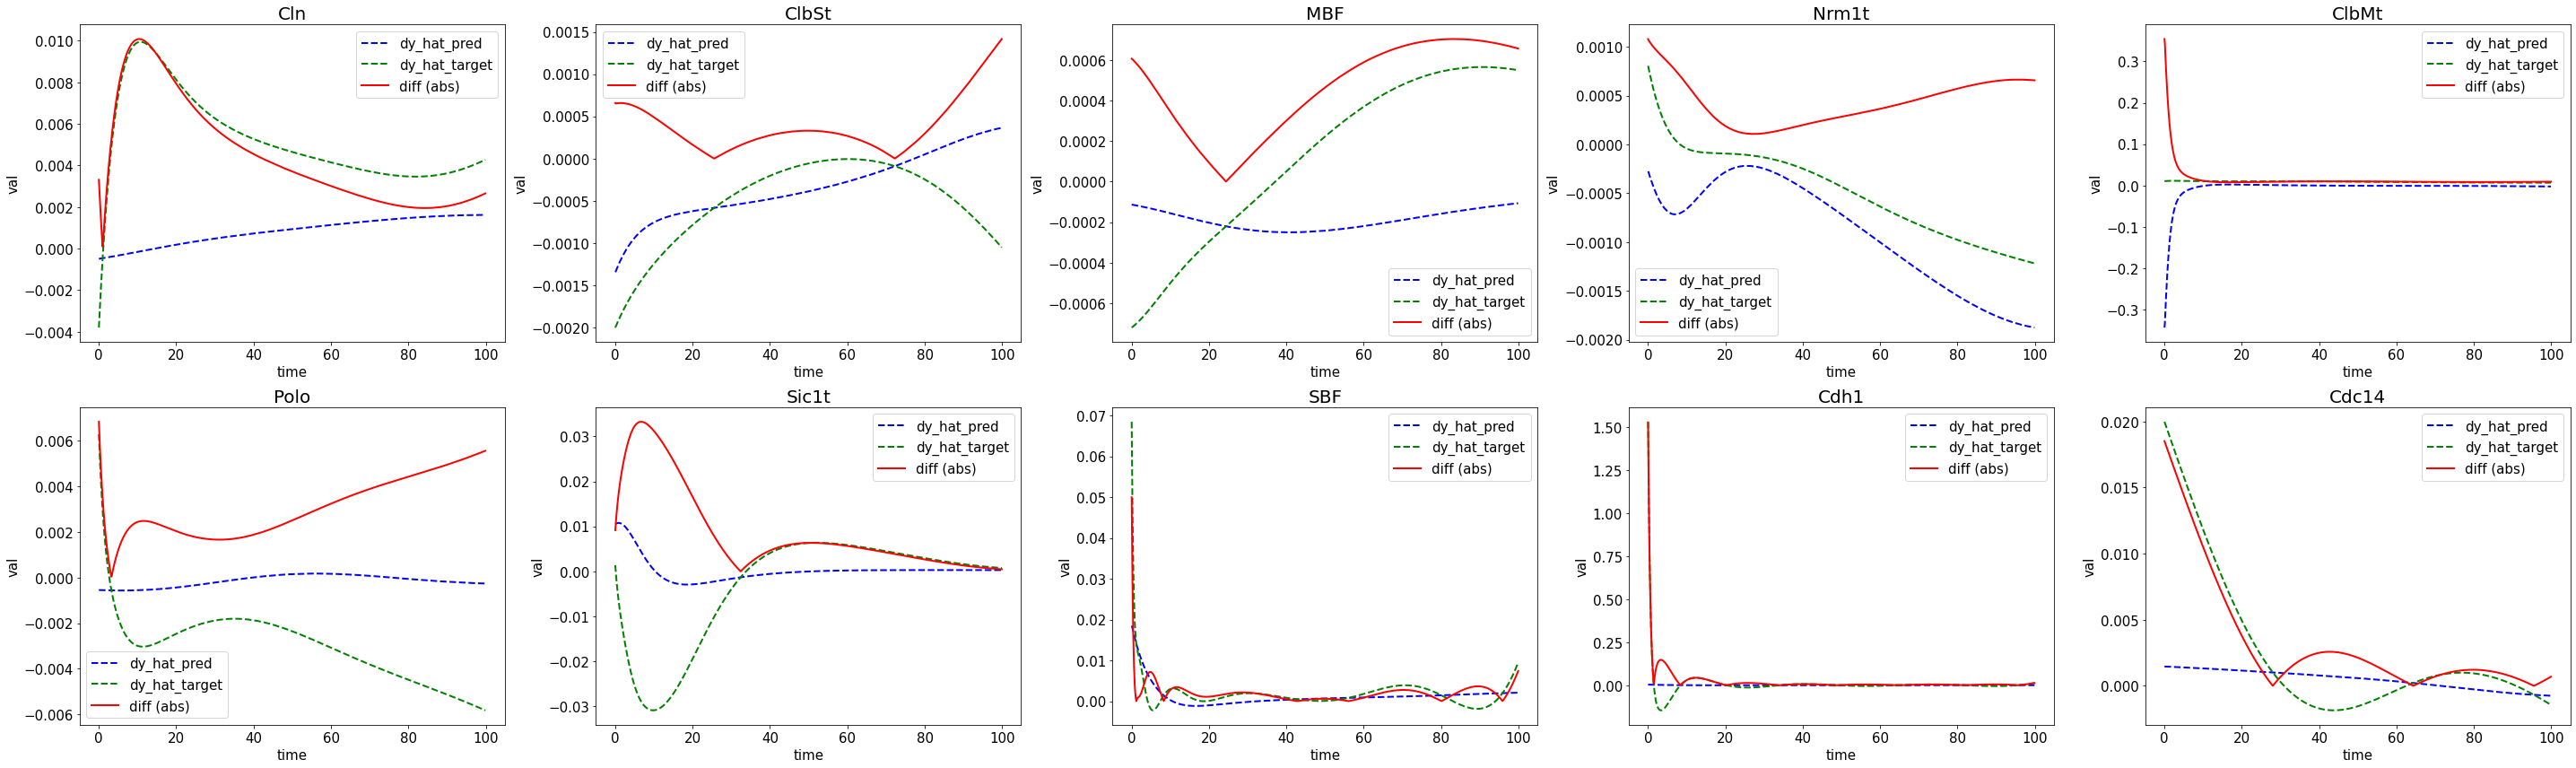

In [ ]:
args = Args
args.main_path = '/content/drive/My Drive/PINN_model_testing' 
model_save_path = "/content/drive/My Drive/enze/workspace/PINN/train/SimpleNetworkBYCCContinue_10000000_1000_0.001_2022-08-16-03-10-46_last.pt" # SimpleNetworkTuring_10000_100_0.01_2022-06-07-08-10-46_last
now_string = get_now_string()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = ConfigBYCCComplete()
model = SimpleNetworkBYCC(config).to(device)
model.load_state_dict(torch.load(model_save_path, map_location=device)["model_state_dict"])

self = model
self.eval()
y = self.forward(self.x)
# Cln = y[:,0:1]
# ClbSt = y[:,1:2]
# MBF = y[:,2:3]
# Nrm1t = y[:,3:4]
# ClbMt = y[:,4:5]
# Polo = y[:,5:6]
# Sic1t = y[:,6:7]
# SBF = y[:,7:8]
# Cdh1 = y[:,8:9]
# Cdc14 = y[:,9:10]

Cln = y[:,0:1]
ClbSt = y[:,1:2]
MBF = y[:,2:3]
Nrm1t = y[:,3:4]
ClbMt = y[:,4:5]
Polo = y[:,5:6]
Sic1t = y[:,6:7]
SBF = y[:,7:8]
Cdh1 = y[:,8:9]
Cdc14 = y[:,9:10]

Cln_t = torch.gradient(Cln.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
ClbSt_t = torch.gradient(ClbSt.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
MBF_t = torch.gradient(MBF.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
Nrm1t_t = torch.gradient(Nrm1t.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
ClbMt_t = torch.gradient(ClbMt.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
Polo_t = torch.gradient(Polo.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
Sic1t_t = torch.gradient(Sic1t.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
SBF_t = torch.gradient(SBF.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
Cdh1_t = torch.gradient(Cdh1.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
Cdc14_t = torch.gradient(Cdc14.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])

Cln_t_target  = kscln*SBF - kdcln*Cln
ClbSt_t_target = ksclbs*(MBF*Cln/(torch.abs(Jmbf + Cln)+1e-12)) - (kdclbs1 + kdclbs*Cdh1)*ClbSt
MBF_t_target  = kdiss1*(MBFtot - MBF) - kass1*MBF*(Nrm1t - (MBFtot - MBF))
Nrm1t_t_target = ksnrm1*(MBF*Cln/(torch.abs(Jmbf + Cln)+1e-12)) - kdnrm1*Cdh1*Nrm1t
ClbMt_t_target = ksclbm1 + ksclbm*((ClbMt+ndClbM)*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12)))/(torch.abs(ClbSt + ClbMt + ndClbM)+1e-12))**n/(torch.abs(Jclbm**n + ((ClbMt + ndClbM)*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12)))/(torch.abs(ClbSt + ClbMt + ndClbM)+1e-12))**n)+1e-12) - (kdclbm1 + kdclbm*Cdh1)*ClbMt
Polo_t_target  = kspolo*((ClbMt+ndClbM)*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12)))/(torch.abs(ClbSt + ClbMt + ndClbM)+1e-12)) - (kdpolo1 + kdpolo*Cdh1)*Polo
Sic1t_t_target = kssic1 - (kdsic1 + kdsic*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12)))*(Cln+((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12))))/(torch.abs(Jsic1+Cln+((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12))))+1e-12))*Sic1t
SBF_t_target  = (kasbf1 + kasbf*Cln)*(1-SBF)/(torch.abs(Jsbf + 1 - SBF)+1e-12) - kisbf*((ClbMt+ndClbM)*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12)))/(torch.abs(ClbSt + ClbMt + ndClbM)+1e-12))*SBF/(torch.abs(Jsbf + SBF)+1e-12)
Cdh1_t_target  = (kacdh11 + kacdh1*Cdc14)*(1 - Cdh1)/(torch.abs(Jcdh1 + 1 - Cdh1)+1e-12) - (kicdh11*Cln + kicdh1*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12))))*Cdh1/(torch.abs(Jcdh1 + Cdh1)+1e-12)
Cdc14_t_target = kacdc14*Polo*(1 - Cdc14)/(torch.abs(Jcdc14 + 1 - Cdc14)+1e-12) - kicdc14*Cdc14/(torch.abs(Jcdc14 + Cdc14)+1e-12)

f_Cln = Cln_t  - Cln_t_target
f_ClbSt = ClbSt_t - ClbSt_t_target
f_MBF = MBF_t  - MBF_t_target
f_Nrm1t = Nrm1t_t - Nrm1t_t_target
f_ClbMt = ClbMt_t - ClbMt_t_target
f_Polo = Polo_t - Polo_t_target 
f_Sic1t = Sic1t_t - Sic1t_t_target
f_SBF = SBF_t  - SBF_t_target
f_Cdh1 = Cdh1_t - Cdh1_t_target 
f_Cdc14 = Cdc14_t - Cdc14_t_target

# print("f_Cln:", f_Cln.shape)
# print("f_ClbSt:", f_ClbSt.shape)
# print("f_MBF:", f_MBF.shape)
# print("f_Nrm1t:", f_Nrm1t.shape)
# print("f_ClbMt:", f_ClbMt.shape)
# print("f_Polo:", f_Polo.shape)
# print("f_Sic1t:", f_Sic1t.shape)
# print("f_SBF:", f_SBF.shape)
# print("f_Cdh1:", f_Cdh1.shape)
# print("f_Cdc14:", f_Cdc14.shape)

f_y = torch.cat((f_Cln, f_ClbSt, f_MBF, f_Nrm1t, f_ClbMt, f_Polo, f_Sic1t, f_SBF, f_Cdh1, f_Cdc14), 1)
zeros_10D = torch.Tensor([[0.0] * 10] * len(f_y)).to(device)
loss_norm = nn.MSELoss()
# print(f_y.shape, zeros_10D.shape)
print(loss_norm(f_y, zeros_10D).item())
# print(torch.mean(torch.square(f_y - zeros_10D)))

# print(Cln_t_target.shape)
# print(Cln_t.shape)
# print(f_Cln.shape)
# print(self.x.shape)
# print(SBF.shape)
# draw_two_dimension(
#     y_lists=[Cln_t_target.cpu().detach().numpy(), Cln_t.cpu().detach().numpy(), np.abs(f_Cln.cpu().detach().numpy())],
#     x_list=self.x[:,0].cpu().detach().numpy().flatten(),
#     color_list=["black", "black", "red"],
#     legend_list=None,
#     line_style_list=["solid", "dotted", "solid"],
#     fig_title=None,
#     fig_size=(8, 6),
#     show_flag=True,
#     save_flag=False,
#     save_path=None
# )
name_list = ["Cln", "ClbSt", "MBF", "Nrm1t", "ClbMt","Polo","Sic1t","SBF","Cdh1","Cdc14"]
item_list = [Cln_t, ClbSt_t, MBF_t, Nrm1t_t, ClbMt_t, Polo_t, Sic1t_t, SBF_t, Cdh1_t, Cdc14_t]
item_target_list = [Cln_t_target, ClbSt_t_target, MBF_t_target, Nrm1t_t_target, ClbMt_t_target, Polo_t_target, Sic1t_t_target, SBF_t_target, Cdh1_t_target, Cdc14_t_target]
color_list = ["red","orange","yellow","green","cyan","blue","purple","pink","indigo","brown"]

m = MultiSubplotDraw(row=2, col=5, fig_size=(40, 12), tight_layout_flag=True)
for name, item, item_target, color in zip(name_list, item_list, item_target_list, color_list):
  f = torch.abs(item - item_target)
  m.add_subplot(
      y_lists=[item.cpu().detach().numpy().flatten(), item_target.cpu().detach().numpy().flatten(), f.cpu().detach().numpy().flatten()],
      x_list=self.accurate_x,
      color_list=["b", "g", "red"],
      legend_list=["dy_hat_pred", "dy_hat_target", "diff (abs)"],
      line_style_list=["dashed", "dashed", "solid"],
      fig_title=name,
  )

m.draw()

[continuous] self.x_real: shape = torch.Size([1000, 10])
self.truth_length: 1 of 1000 all 
[Continue] loss_1_start_index  0


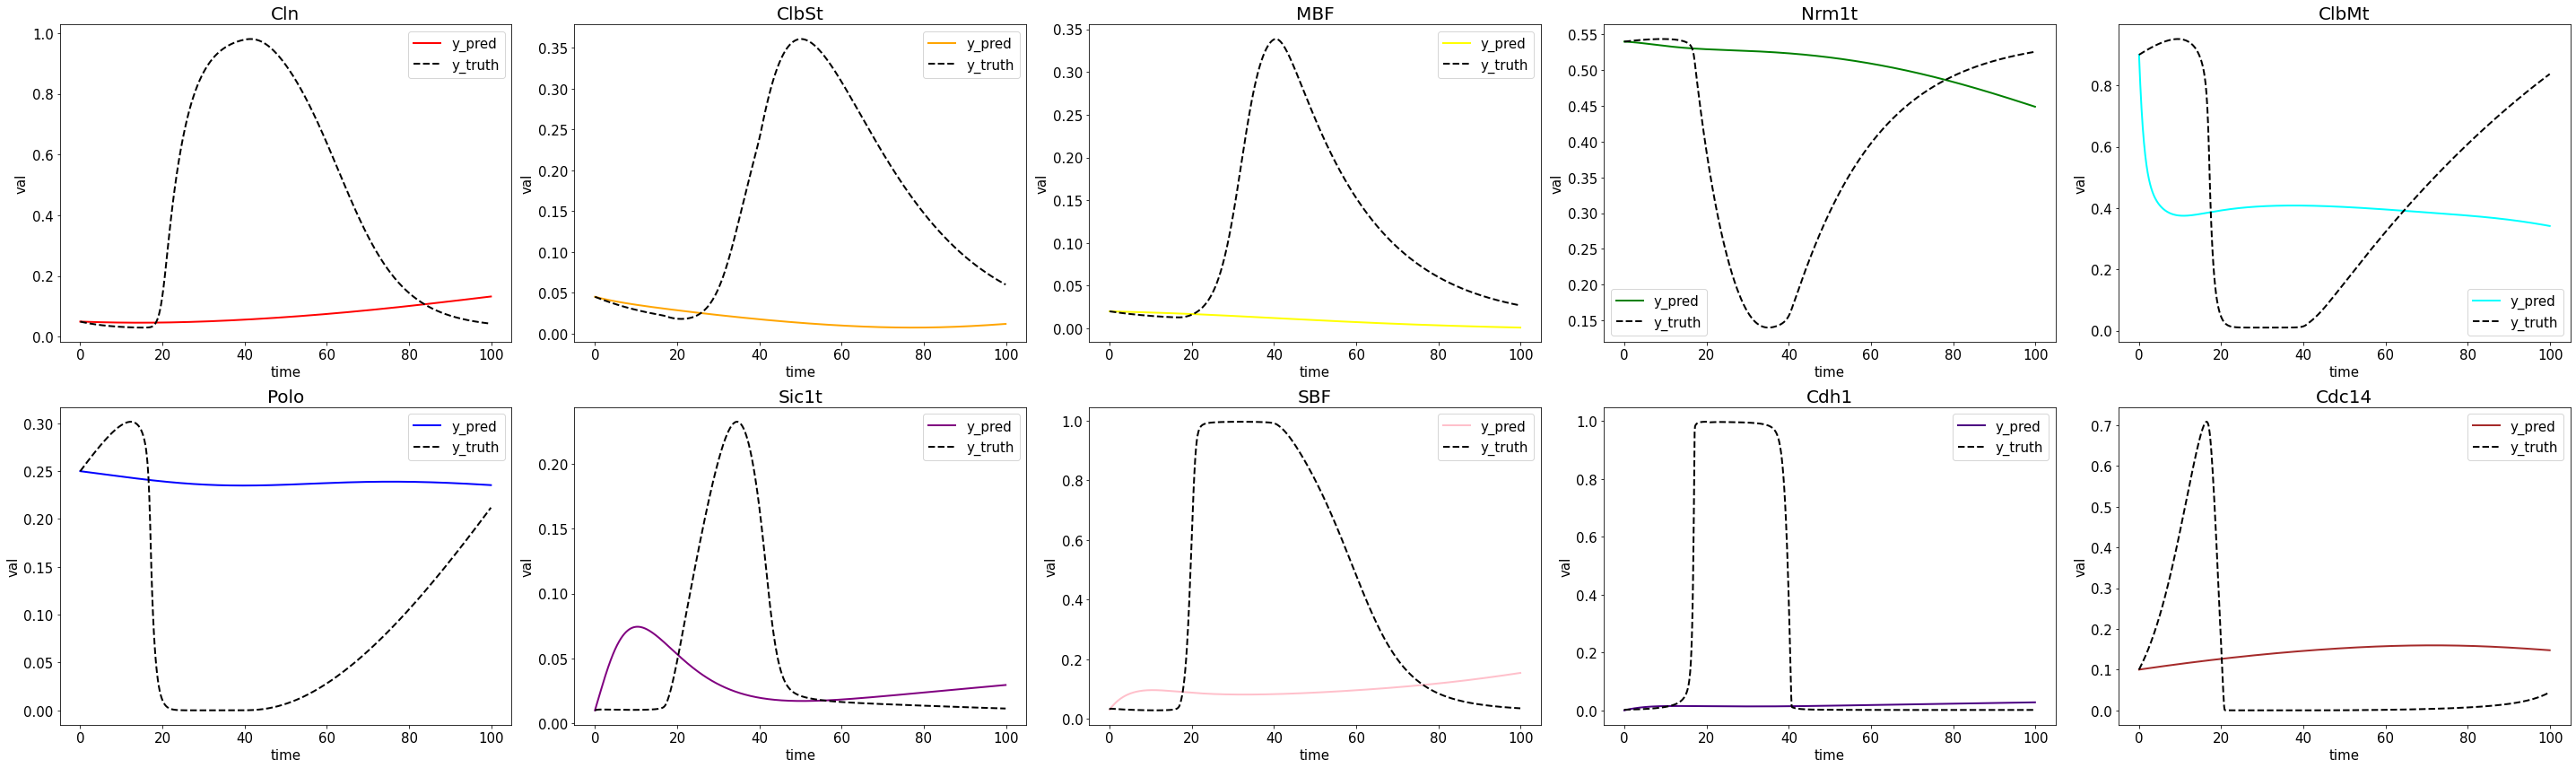

In [ ]:
#draw y_true vs y_pred
args = Args
args.main_path = '/content/drive/My Drive/PINN_model_testing' 
model_save_path = "/content/drive/My Drive/enze/workspace/PINN/train/SimpleNetworkBYCCContinue_10000000_1000_0.001_2022-08-16-03-10-46_last.pt" # SimpleNetworkTuring_10000_100_0.01_2022-06-07-08-10-46_last
now_string = get_now_string()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = ConfigBYCCComplete()
model = SimpleNetworkBYCC(config).to(device)
model.load_state_dict(torch.load(model_save_path, map_location=device)["model_state_dict"])

self = model
self.eval()
y = self.forward(self.x)
Cln = y[:,0:1]
ClbSt = y[:,1:2]
MBF = y[:,2:3]
Nrm1t = y[:,3:4]
ClbMt = y[:,4:5]
Polo = y[:,5:6]
Sic1t = y[:,6:7]
SBF = y[:,7:8]
Cdh1 = y[:,8:9]
Cdc14 = y[:,9:10]


y = self.gt_data
Cln_true = y[:,0:1]
ClbSt_true = y[:,1:2]
MBF_true = y[:,2:3]
Nrm1t_true = y[:,3:4]
ClbMt_true = y[:,4:5]
Polo_true = y[:,5:6]
Sic1t_true = y[:,6:7]
SBF_true = y[:,7:8]
Cdh1_true = y[:,8:9]
Cdc14_true = y[:,9:10]


name_list = ["Cln", "ClbSt", "MBF", "Nrm1t", "ClbMt","Polo","Sic1t","SBF","Cdh1","Cdc14"]
item_list = [Cln, ClbSt, MBF, Nrm1t, ClbMt, Polo, Sic1t, SBF, Cdh1, Cdc14]
item_target_list = [Cln_true, ClbSt_true, MBF_true, Nrm1t_true, ClbMt_true, Polo_true, Sic1t_true, SBF_true, Cdh1_true, Cdc14_true]
color_list = ["red","orange","yellow","green","cyan","blue","purple","pink","indigo","brown"]

m = MultiSubplotDraw(row=2, col=5, fig_size=(40, 12), tight_layout_flag=True)
for name, item, item_target, color in zip(name_list, item_list, item_target_list, color_list):
  m.add_subplot(
      y_lists=[item.cpu().detach().numpy().flatten(), item_target.cpu().detach().numpy().flatten()],
      x_list=self.accurate_x,
      color_list=[color, "black"],
      legend_list=["y_pred", "y_truth"],
      line_style_list=["solid", "dashed"],
      fig_title=name,
  )

m.draw()

[continuous] self.x_real: shape = torch.Size([1000, 10])
self.truth_length: 1 of 1000 all 
[Continue] loss_1_start_index  0
f_Cln: torch.Size([1000, 1])
f_ClbSt: torch.Size([1000, 1])
f_MBF: torch.Size([1000, 1])
f_Nrm1t: torch.Size([1000, 1])
f_ClbMt: torch.Size([1000, 1])
f_Polo: torch.Size([1000, 1])
f_Sic1t: torch.Size([1000, 1])
f_SBF: torch.Size([1000, 1])
f_Cdh1: torch.Size([1000, 1])
f_Cdc14: torch.Size([1000, 1])
0.00023204984609037638


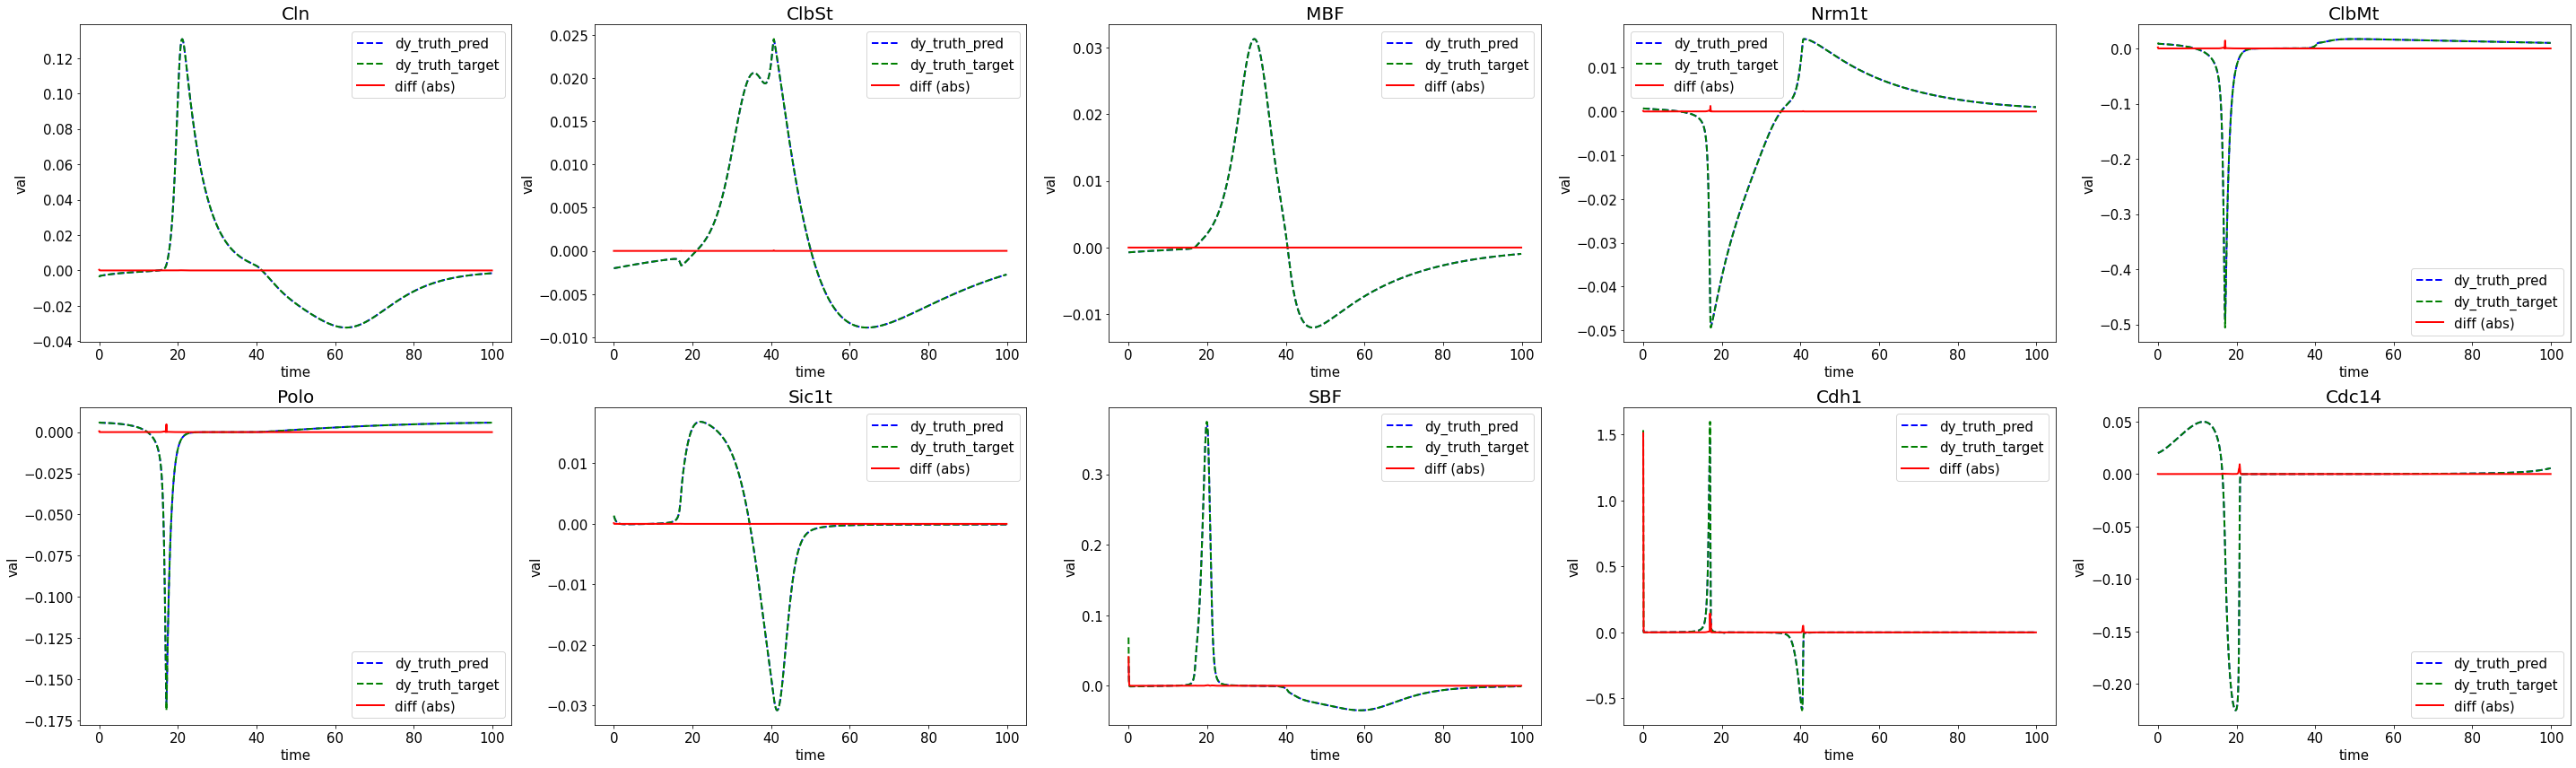

In [ ]:
# draw gt
args = Args
args.main_path = '/content/drive/My Drive/PINN_model_testing' 
model_save_path = "/content/drive/My Drive/enze/workspace/PINN/train/SimpleNetworkBYCCContinue_10000000_1000_0.001_2022-08-16-03-10-46_last.pt" # SimpleNetworkTuring_10000_100_0.01_2022-06-07-08-10-46_last
now_string = get_now_string()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = ConfigBYCCComplete()
model = SimpleNetworkBYCC(config).to(device)
model.load_state_dict(torch.load(model_save_path, map_location=device)["model_state_dict"])

self = model
self.eval()
y = self.gt_data
# Cln = y[:,0:1]
# ClbSt = y[:,1:2]
# MBF = y[:,2:3]
# Nrm1t = y[:,3:4]
# ClbMt = y[:,4:5]
# Polo = y[:,5:6]
# Sic1t = y[:,6:7]
# SBF = y[:,7:8]
# Cdh1 = y[:,8:9]
# Cdc14 = y[:,9:10]

Cln = y[:,0:1]
ClbSt = y[:,1:2]
MBF = y[:,2:3]
Nrm1t = y[:,3:4]
ClbMt = y[:,4:5]
Polo = y[:,5:6]
Sic1t = y[:,6:7]
SBF = y[:,7:8]
Cdh1 = y[:,8:9]
Cdc14 = y[:,9:10]

Cln_t = torch.gradient(Cln.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
ClbSt_t = torch.gradient(ClbSt.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
MBF_t = torch.gradient(MBF.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
Nrm1t_t = torch.gradient(Nrm1t.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
ClbMt_t = torch.gradient(ClbMt.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
Polo_t = torch.gradient(Polo.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
Sic1t_t = torch.gradient(Sic1t.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
SBF_t = torch.gradient(SBF.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
Cdh1_t = torch.gradient(Cdh1.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])
Cdc14_t = torch.gradient(Cdc14.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1])

Cln_t_target  = kscln*SBF - kdcln*Cln
ClbSt_t_target = ksclbs*(MBF*Cln/(torch.abs(Jmbf + Cln)+1e-12)) - (kdclbs1 + kdclbs*Cdh1)*ClbSt
MBF_t_target  = kdiss1*(MBFtot - MBF) - kass1*MBF*(Nrm1t - (MBFtot - MBF))
Nrm1t_t_target = ksnrm1*(MBF*Cln/(torch.abs(Jmbf + Cln)+1e-12)) - kdnrm1*Cdh1*Nrm1t
ClbMt_t_target = ksclbm1 + ksclbm*((ClbMt+ndClbM)*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12)))/(torch.abs(ClbSt + ClbMt + ndClbM)+1e-12))**n/(torch.abs(Jclbm**n + ((ClbMt + ndClbM)*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12)))/(torch.abs(ClbSt + ClbMt + ndClbM)+1e-12))**n)+1e-12) - (kdclbm1 + kdclbm*Cdh1)*ClbMt
Polo_t_target  = kspolo*((ClbMt+ndClbM)*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12)))/(torch.abs(ClbSt + ClbMt + ndClbM)+1e-12)) - (kdpolo1 + kdpolo*Cdh1)*Polo
Sic1t_t_target = kssic1 - (kdsic1 + kdsic*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12)))*(Cln+((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12))))/(torch.abs(Jsic1+Cln+((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12))))+1e-12))*Sic1t
SBF_t_target  = (kasbf1 + kasbf*Cln)*(1-SBF)/(torch.abs(Jsbf + 1 - SBF)+1e-12) - kisbf*((ClbMt+ndClbM)*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12)))/(torch.abs(ClbSt + ClbMt + ndClbM)+1e-12))*SBF/(torch.abs(Jsbf + SBF)+1e-12)
Cdh1_t_target  = (kacdh11 + kacdh1*Cdc14)*(1 - Cdh1)/(torch.abs(Jcdh1 + 1 - Cdh1)+1e-12) - (kicdh11*Cln + kicdh1*((ClbSt + ClbMt + ndClbM) - (2*Sic1t*(ClbSt + ClbMt + ndClbM)/(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss) + torch.sqrt(torch.abs((Sic1t + (ClbSt + ClbMt + ndClbM) + Kdiss)**2 -4*Sic1t*(ClbSt + ClbMt + ndClbM))+1e-12))+1e-12))))*Cdh1/(torch.abs(Jcdh1 + Cdh1)+1e-12)
Cdc14_t_target = kacdc14*Polo*(1 - Cdc14)/(torch.abs(Jcdc14 + 1 - Cdc14)+1e-12) - kicdc14*Cdc14/(torch.abs(Jcdc14 + Cdc14)+1e-12)

f_Cln = Cln_t  - Cln_t_target
f_ClbSt = ClbSt_t - ClbSt_t_target
f_MBF = MBF_t  - MBF_t_target
f_Nrm1t = Nrm1t_t - Nrm1t_t_target
f_ClbMt = ClbMt_t - ClbMt_t_target
f_Polo = Polo_t - Polo_t_target 
f_Sic1t = Sic1t_t - Sic1t_t_target
f_SBF = SBF_t  - SBF_t_target
f_Cdh1 = Cdh1_t - Cdh1_t_target 
f_Cdc14 = Cdc14_t - Cdc14_t_target

print("f_Cln:", f_Cln.shape)
print("f_ClbSt:", f_ClbSt.shape)
print("f_MBF:", f_MBF.shape)
print("f_Nrm1t:", f_Nrm1t.shape)
print("f_ClbMt:", f_ClbMt.shape)
print("f_Polo:", f_Polo.shape)
print("f_Sic1t:", f_Sic1t.shape)
print("f_SBF:", f_SBF.shape)
print("f_Cdh1:", f_Cdh1.shape)
print("f_Cdc14:", f_Cdc14.shape)

f_y = torch.cat((f_Cln, f_ClbSt, f_MBF, f_Nrm1t, f_ClbMt, f_Polo, f_Sic1t, f_SBF, f_Cdh1, f_Cdc14), 1)
zeros_10D = torch.Tensor([[0.0] * 10] * len(f_y)).to(device)
loss_norm = nn.MSELoss()
# print(f_y.shape, zeros_10D.shape)
print(loss_norm(f_y, zeros_10D).item())
# print(torch.mean(torch.square(f_y - zeros_10D)))

# print(Cln_t_target.shape)
# print(Cln_t.shape)
# print(f_Cln.shape)
# print(self.x.shape)
# print(SBF.shape)
# draw_two_dimension(
#     y_lists=[Cln_t_target.cpu().detach().numpy(), Cln_t.cpu().detach().numpy(), np.abs(f_Cln.cpu().detach().numpy())],
#     x_list=self.x[:,0].cpu().detach().numpy().flatten(),
#     color_list=["black", "black", "red"],
#     legend_list=None,
#     line_style_list=["solid", "dotted", "solid"],
#     fig_title=None,
#     fig_size=(8, 6),
#     show_flag=True,
#     save_flag=False,
#     save_path=None
# )
name_list = ["Cln", "ClbSt", "MBF", "Nrm1t", "ClbMt","Polo","Sic1t","SBF","Cdh1","Cdc14"]
item_list = [Cln_t, ClbSt_t, MBF_t, Nrm1t_t, ClbMt_t, Polo_t, Sic1t_t, SBF_t, Cdh1_t, Cdc14_t]
item_target_list = [Cln_t_target, ClbSt_t_target, MBF_t_target, Nrm1t_t_target, ClbMt_t_target, Polo_t_target, Sic1t_t_target, SBF_t_target, Cdh1_t_target, Cdc14_t_target]
color_list = ["red","orange","yellow","green","cyan","blue","purple","pink","indigo","brown"]

m = MultiSubplotDraw(row=2, col=5, fig_size=(40, 12), tight_layout_flag=True)
for name, item, item_target, color in zip(name_list, item_list, item_target_list, color_list):
  f = torch.abs(item - item_target)
  m.add_subplot(
      y_lists=[item.cpu().detach().numpy().flatten(), item_target.cpu().detach().numpy().flatten(), f.cpu().detach().numpy().flatten()],
      x_list=self.accurate_x,
      color_list=["b", "g", "red"],
      legend_list=["dy_truth_pred", "dy_truth_target", "diff (abs)"],
      line_style_list=["dashed", "dashed", "solid"],
      fig_title=name,
  )

m.draw()